# Predicting Flight Delays

The ogjective of this project is to use historical flight information to create a classification model that can return the probability of a flight being delayed. 

We will be looking at data from 2016, 2017, and 2018. All data files are downloaded from OST website, which stores flights on-time performance fro 1987 to present.

**Our MVP**: Our MVP will look to just deliver predictions and exploration on the flight data. Once the MVP is completed, I will look to bring in weather data.


In addition to the data that we are bringing, we will also be using weather data. 

As stated in a published paper by 

> "Our analysis shows that weather shocks like rainfall, snow and wind have a significant impact on departure delays within the U.S. aviation system. Depending on the intensity of the weather shock considered, rain- and snowfall lead to additional departure delays between 10 and 23 min. For wind, the discovered effects are smaller in magnitude, ranging from 1 to 3 min. While the impact of rainfall is more pronounced between April and September, the effect of wind is more evenly distributed across the year. With regard to slow onset weather shocks, our results reveal that cold conditions lead to additional departure delays. For temperatures below 0∘C, our analysis shows an increase in delay on average by around 2 min per departure. For heat, we do not discover any significant amplifying impacts on departure delay. While our results indicate a tendency of higher average departure delays when temperatures go beyond 45∘C, the results are not statistically significant. Considering the recent experiences from Phoenix, where temperatures of 49∘C on June 20th, 2017 lead to the cancellation of more than 40 regional flights, together with the projections by Coffel et al. (2017), we expect extreme temperatures to increase departure delays.8 Our observations for temperatures beyond 45∘C, however, are insufficient for robust estimates."$^1$



$^1$Borsky, S and Unterberger, C (2019) ‘Bad weather and flight delays: The impact of sudden and slow onset weather events’, Economics of Transportation, Volume 18.

The weather data comes from:

Moosavi, Sobhan, Mohammad Hossein Samavatian, Arnab Nandi, Srinivasan Parthasarathy, and Rajiv Ramnath. “Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data.” In Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, ACM, 2019.

In [1]:
import pandas as pd
import numpy as np

import os.path
import requests
import io

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import GradientBoostingClassifier

import wrangle
import model

# Acquistion

In [2]:
# df = pd.read_csv("https://raw.githubusercontent.com/michaelarg/datasets/master/airports.csv")

# airports = df[df.Country == "United States"]

# weather_data = pd.read_csv("US_WeatherEvents_2016-2019.csv")

In [3]:
df = pd.read_csv("2018.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM      int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtypes: float64(20), int64(3),

Given that there is a large amount of data (+1.5GB), we will filter down to the top 15 largest airports. This will be at least for the exploration phase. We may look to bring additional data once we are ready to model.

In [5]:
top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

for i in top_airports:
    df.loc[df['ORIGIN'] == i, 'is_top'] = True 
    
df.is_top = df.is_top.fillna(False)

In [8]:
# How many datapoints are there per airport? 

df[df.is_top].ORIGIN.value_counts()

ATL    390046
ORD    332953
DFW    279298
DEN    235989
CLT    233317
LAX    221486
SFO    175849
PHX    173962
IAH    173806
LAS    161113
EWR    143875
SEA    140006
MCO    138296
JFK    129684
MIA     87880
Name: ORIGIN, dtype: int64

In [9]:
# Let's reassign the dataframe so that we only have our top airports

df = df[df.is_top]

In [10]:
# What does our new dataframe look like?

df.shape  

(3017560, 29)

In [11]:
# How many null values do we have?

df.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 40437
DEP_DELAY                41790
TAXI_OUT                 41892
WHEELS_OFF               41892
WHEELS_ON                43585
TAXI_IN                  43585
CRS_ARR_TIME                 0
ARR_TIME                 43585
ARR_DELAY                50550
CANCELLED                    0
CANCELLATION_CODE      2975227
DIVERTED                     0
CRS_ELAPSED_TIME             2
ACTUAL_ELAPSED_TIME      49843
AIR_TIME                 49843
DISTANCE                     0
CARRIER_DELAY          2416987
WEATHER_DELAY          2416987
NAS_DELAY              2416987
SECURITY_DELAY         2416987
LATE_AIRCRAFT_DELAY    2416987
Unnamed: 27            3017560
is_top                       0
dtype: int64

We see that even after only keeping the top 15 airports, we stll have a lot of NULL values. We will do some further exploration to figure out what we can remove, and what we need to keep.

In [13]:
df.drop(columns = ["Unnamed: 27", "is_top", "CANCELLATION_CODE"], inplace=True)

In [14]:
df = df[df.ARR_DELAY.notnull()]

In [15]:
df = df[df.DEP_DELAY.notnull()]

In [16]:
df = df.fillna(0.0)

In [17]:
df.isnull().sum()

FL_DATE                0
OP_CARRIER             0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

We see that we largely were able to get rid of any null values. It seems that `Cancelation_code` has no remaining values, we so will drop that column. 

In [18]:
# let's lower case the column names to make it easier to access them

df.columns = map(str.lower, df.columns)

In [19]:
# lets add the airline names

airline_code = pd.read_csv("airline_codes.csv")

airline_code.drop(columns="Unnamed: 0", inplace=True)

In [20]:
df = df.merge(airline_code, how="left", left_on="op_carrier", right_on = "Code")

In [21]:
df.drop(columns="Code", inplace=True)

Now that we have the data in the shape that we want it it, we are ready to move onto exploration

# Exploration

We will look to understand if there are any patterns that can help us predict if a flight will be delayed.

The objective is to see if there are significantly different groupings based on our target variable, as these would be extremly useful for modeling.

## What percentage of flights experience delays?

In [22]:
print(f"{(df.arr_delay > 0).mean():.0%} of flights experienced a delay in 2018")

37% of flights experienced a delay in 2018


Text(0.5, 0, 'Minutes Delayed')

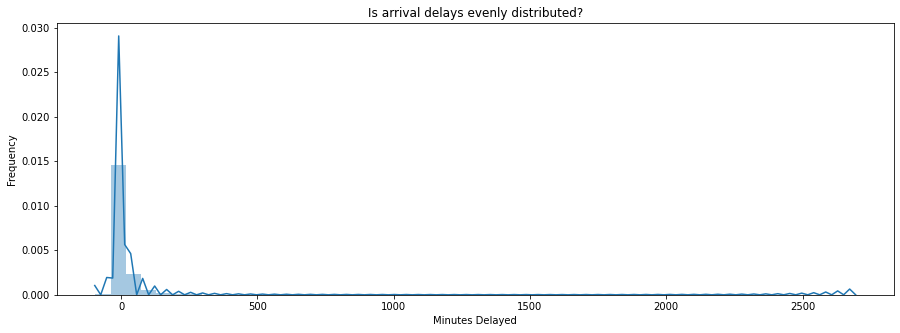

In [23]:
# Is arr delay evenly distributed?

plt.figure(figsize=(15,5))
sns.distplot(df.arr_delay)
plt.title("Is arrival delays evenly distributed?")
plt.ylabel("Frequency")
plt.xlabel("Minutes Delayed")

As we can see, the data is infact not normally distributed. This means that there are a lot of outliers. I won't remove the ourliers at this point, however, as we want to preserve as many data points as possible, particularly for the time series exploration. If we find that they are skewing the data too much, we will look to remove them using the IQR method.


This will likely have an effect on any statistical testing, however, as these tests assume that the data is normally distributed.

## What airline carrier experiences the most delays?

* $H_0$: There is no difference in mean between all the carriers in avg minutes of delays
* $H_a$: There is a difference in mean between all the carriers in avg minutes of delays

Text(0.5, 0, 'Airline Code')

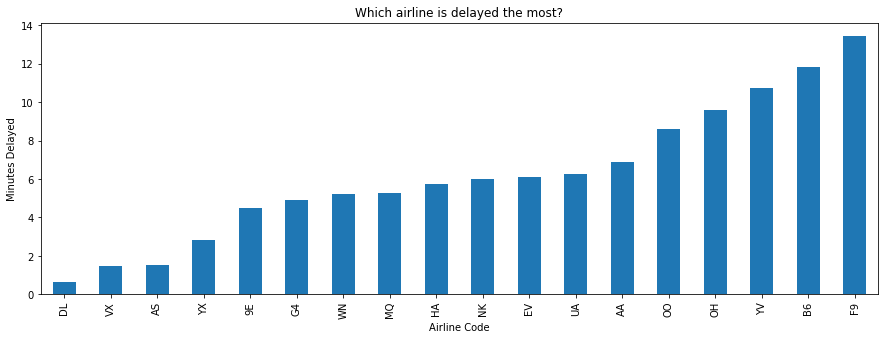

In [24]:
# Delays in minutes
df.groupby("op_carrier").arr_delay.mean().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airline is delayed the most?")
plt.ylabel("Minutes Delayed")
plt.xlabel("Airline Code")

It seems that Frontier had the longest delays, with an average of 13 min delay across 2018. Delta had the overall smallest delays in minutes, with an average of 0.6 min for 2018.

Given that there are 18 unique airlines, we will not perform an ANOVA test, an instead will assume that the data is significant. Given the evidence in the graph, and the fact that we have nearly 2 million datapoints, I suspect we would get a very low p value anyways.

Text(0.5, 0, 'Airline Code')

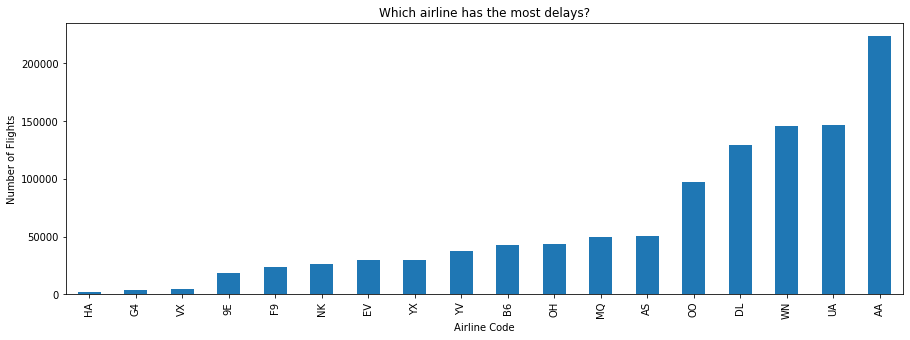

In [25]:
# Delays by flights (count)

df[df.arr_delay > 0].groupby("op_carrier").arr_delay.count().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airline has the most delays?")
plt.ylabel("Number of Flights")
plt.xlabel("Airline Code")

Interestingly, American Airlines seems to have the most flights delayed. I think this is more indicative of which airlines have most scheduled flights. If we want to look at better metric of delays, we should use minutes delayed.

## What airport experience the most delays?

* $H_0$: There is no mean difference in minutes delayed by airport
* $H_a$: There is a difference in minutes delayed by airport

Text(0.5, 0, 'Airline Code')

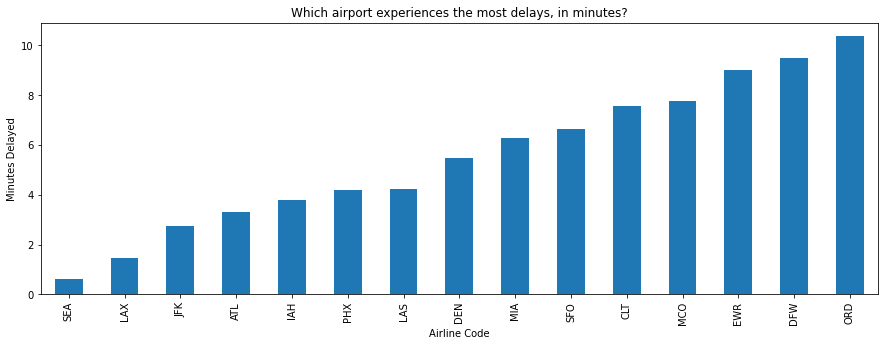

In [26]:
# Delays in minutes
df.groupby("origin").arr_delay.mean().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airport experiences the most delays, in minutes?")
plt.ylabel("Minutes Delayed")
plt.xlabel("Airline Code")

Text(0.5, 0, 'Airline Code')

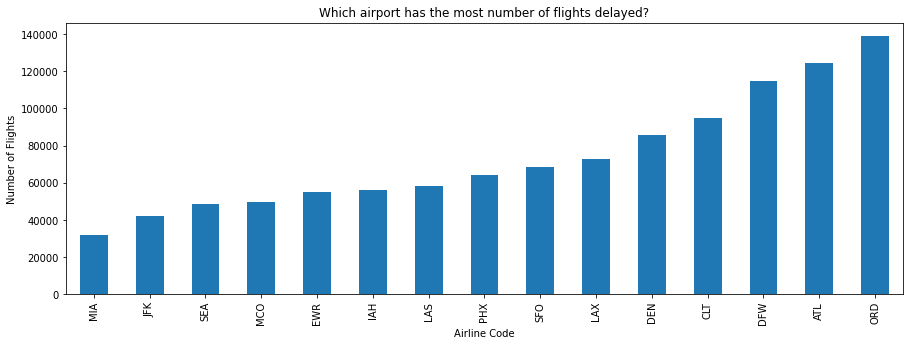

In [27]:
df[df.arr_delay > 0].groupby("origin").arr_delay.count().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airport has the most number of flights delayed?")
plt.ylabel("Number of Flights")
plt.xlabel("Airline Code")

Interestingly, Orland seems to have the most delays both in number of flights delayed by more than a minute, and avg minutes delayed. Some ideas that might help explain these results:

1. Look at airports that recieve the most international flights
1. Look at what airports have hubs for what airlines. Given that we know that overall some airlines have a higher propensity to experience delays, it might be that this has an effect on delays by airports.

I initially though that weather might have an impact on this - as Orlando could experience high humidity, however Miami is on the other side of the spectrum, and I would suspect they would have similar weather.

We know Atlanta and LAX are the busiest airports in terms of total number of flights.

Again, given that there are 15 unique airports, we won't conduct an ANOVA test. We will assume that the data is statistically significant.

## What is the most common type of delay?

* $H_0$: There is no difference in mean minutes delayed between the different delay types
* $H_a$: There is a difference in mean minutes delayed between the different delay types

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2965760 entries, 0 to 2965759
Data columns (total 27 columns):
fl_date                object
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
dtypes: float64(19), int64(3), object(5)
memory usage: 633.6+

Text(0.5, 0, 'Reason for delay')

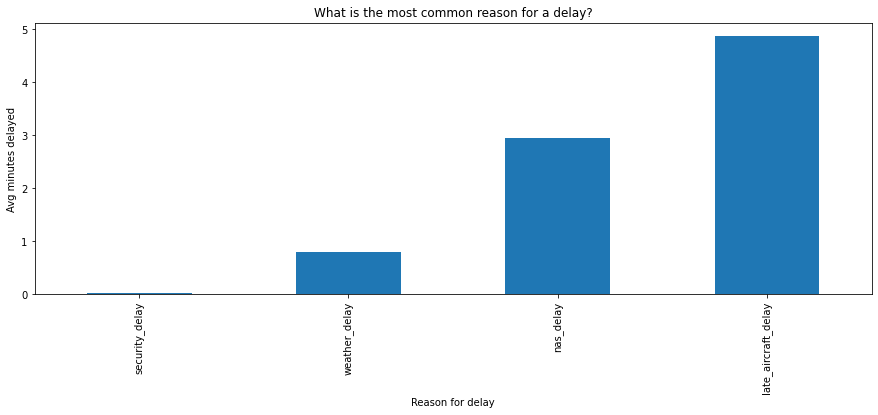

In [29]:
df.iloc[:,22:26].mean().sort_values().plot.bar(figsize=(15,5))
plt.title("What is the most common reason for a delay?")
plt.ylabel("Avg minutes delayed")
plt.xlabel("Reason for delay")

It seems that a late aircraft arrival is the main cause for delays. This raises more questions, as now we may have to not only look at the weather and factor of the previous flights (which means we will need to definitively look at the flight number). 

We might be able to use this information to track inbound [flights]https://flightaware.com/live/flight/UAL208/history/20200709/2205Z/KATL/KIAH

If we could find a way to actually scrape the previous airport, we might be able to get additional data to enhance the model's effectiveness.

In [30]:
# ANOVA
stat, pvalue = stats.f_oneway(df.security_delay, df.weather_delay, df.nas_delay, df.late_aircraft_delay)

print(f"p value:{pvalue}")

p value:0.0


Given that our p value is lower than our alpha, we can reject the null hypothesis, and assume that there is a significant difference between the groups.

## Are delays more or less common when the destination is another major airport?

* $H_0$: The airport destination does no make a mean difference in minutes delayed
* $H_a$: The airport destination does make a mean difference in minutes delayed

$\alpha$ = 0.05

In [31]:
for i in top_airports:
    df.loc[df['dest'] == i, 'is_top'] = True
    
df.is_top = df.is_top.fillna(False)

In [32]:
df[df.is_top].arr_delay.mean()

5.972897744384738

In [33]:
df[~df.is_top].arr_delay.mean()

5.636822310970039

In [34]:
subgroup_1 = df[df.is_top].arr_delay
subgroup_2 = df[~df.is_top].arr_delay

tstat, p = stats.ttest_ind(subgroup_1, subgroup_2)

print(f"p value: {p:.2f}")

p value: 0.00


As we can see, our p value is smaller than our alpha, and as such we can reject the null hypothesis. In this case, we can assume that if the destination airport is another major airport, we can expect higher delayes. This, however, should be taken with some caution, as we are dealing with a very high number of data points, and this could have an influence on the test.

## Is there a time series element to delays?

Elements to look for:

* Yearly seasonality
* Month
* Day of week
* Hourly

In [35]:
df.fl_date = pd.to_datetime(df.fl_date)

In [36]:
df = df.set_index("fl_date")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2965760 entries, 2018-01-01 to 2018-12-31
Data columns (total 27 columns):
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
is_top                 bool
dtypes: bool(1), float64(19), int64(3), object(4

In [38]:
monthly = df.resample("M").mean()

Text(0.5, 0, 'Date')

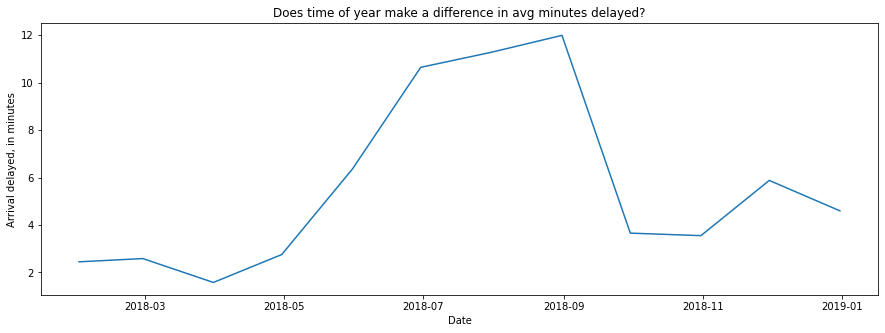

In [39]:
plt.figure(figsize=(15,5))
sns.lineplot(data=monthly, x=monthly.index, y="arr_delay")
plt.title("Does time of year make a difference in avg minutes delayed?")
plt.ylabel("Arrival delayed, in minutes")
plt.xlabel("Date")

We see that there ceirtainly seems to be a seasonality that could be impacting flight delays. It seems that over the summer is when delayes peak. This is likely related to an increase in travel from school breaks as well as summer holidays. We do see a small spike in December, which likely shows people traveling for Christmas. 

## Is there a difference in day of the week delay?

* $H_0$: There is no mean difference in arrival delays between the days of the week
* $H_a$: There is a mean difference in arrival delays between the days of the week

In [40]:
df = df.reset_index()

In [41]:
df["day_name"] = df.fl_date.dt.day_name()

Text(0, 0.5, 'Arrival delay, in minutes')

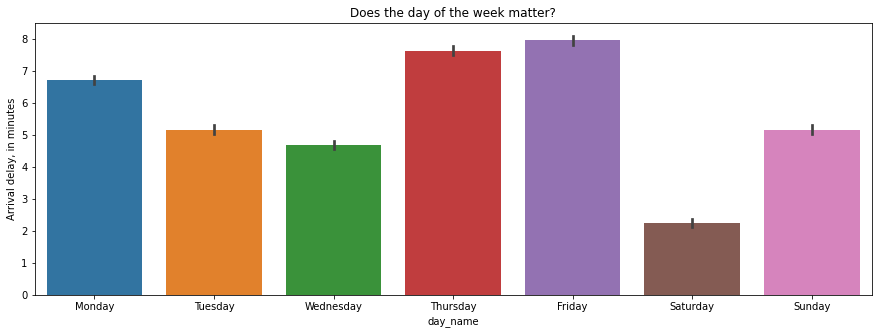

In [42]:
plt.figure(figsize=(15,5))
sns.barplot(data=df, x="day_name", y="arr_delay")
plt.title("Does the day of the week matter?")
plt.ylabel("Arrival delay, in minutes")

In [43]:
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Airline,is_top,day_name
0,2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,...,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday
1,2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,...,65.0,414.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday
2,2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,...,83.0,723.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,Monday
3,2018-01-01,UA,2422,ORD,OMA,2241,2244.0,3.0,15.0,2259.0,...,62.0,416.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,Monday
4,2018-01-01,UA,2421,IAH,LAS,750,747.0,-3.0,14.0,801.0,...,173.0,1222.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday


In [44]:
monday = df[df.day_name == "Monday"].arr_delay
tuesday = df[df.day_name == "Tuesday"].arr_delay
wed = df[df.day_name == "Wednesday"].arr_delay
thur = df[df.day_name == "Thursday"].arr_delay
fri = df[df.day_name == "Friday"].arr_delay
sat = df[df.day_name == "Saturday"].arr_delay
sun = df[df.day_name == "Sunday"].arr_delay

# ANOVA
stat, pvalue = stats.f_oneway(monday, tuesday, wed, thur, fri, sat, sun)

print(f"p value: {pvalue}")

p value: 0.0


Given that our p value is zero, we can reject the null hypothesis, and assume that there is a significant difference in the day of the week and the avg minutes of delays.

It seems that there is ceirtainly some big difference, with Saturday experiencing the least number of delays, and Thursday and Friday having the most. This kind of makes sense, as you would expect most people to travel on a Thursday or Friday (to take advantage of the long weekends) and then return Sunday. Satuday is likely on of the least traveled days.

## Is there a difference in avg minutes delay based on the time of day?

In [45]:
df["crs_dep_time"] = df['crs_dep_time'].astype(str).apply(lambda x: x.zfill(4))

In [46]:
df["crs_dep_time"] = pd.to_datetime(df.crs_dep_time, format= "%H%M")

Text(0.5, 0, 'Dept Time')

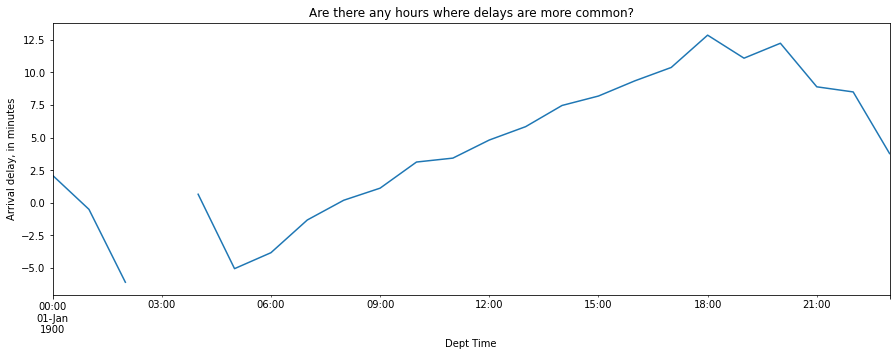

In [47]:
df.set_index("crs_dep_time").arr_delay.resample("1H").mean().plot.line(figsize=(15,5))
plt.title("Are there any hours where delays are more common?")
plt.ylabel("Arrival delay, in minutes")
plt.xlabel("Dept Time")

It seems that the flights that get most delayed are those in the afternoon, between 4 pm and 9 pm. It also seems that there are no flights between 2 am and 4 am. It seems that there seems to be a small peak in delays at around the time when the airpot opens.

In [48]:
df.head()

,fl_date,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Airline,is_top,day_name
0,2018-01-01,UA,2429,EWR,DEN,1900-01-01 15:17:00,1512.0,-5.0,15.0,1527.0,...,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday
1,2018-01-01,UA,2427,LAS,SFO,1900-01-01 11:15:00,1107.0,-8.0,11.0,1118.0,...,65.0,414.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday
2,2018-01-01,UA,2424,ORD,ALB,1900-01-01 06:30:00,650.0,20.0,13.0,703.0,...,83.0,723.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,Monday
3,2018-01-01,UA,2422,ORD,OMA,1900-01-01 22:41:00,2244.0,3.0,15.0,2259.0,...,62.0,416.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,Monday
4,2018-01-01,UA,2421,IAH,LAS,1900-01-01 07:50:00,747.0,-3.0,14.0,801.0,...,173.0,1222.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,Monday


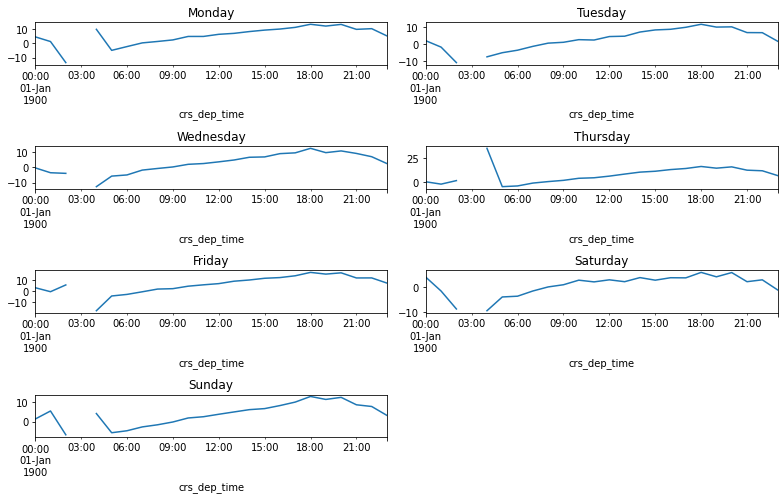

In [49]:
# can we look at it by day of the week?

fig = plt.figure(figsize=(11,8))
days_of_week = df.day_name.unique()
for count, day in enumerate(days_of_week):    
    plt.subplot(5, 2, 1+count)
    df[df.day_name == day].set_index("crs_dep_time").arr_delay.resample("1H").mean().plot.line()
    plt.title(day)

    fig.tight_layout()

plt.show()


As we can see - it seems that regarless of the day of the week, it seems that the peak in delays is always in the evening, between 6 pm and 9 pm. The only exeption is Thursdays, which suprisingly has a long delays at 4 am. I suspect this is one outlier that is pushing the data towards a peak.

## What percentage of flights had a delayed departure, but still reached their destination on time?

In [50]:
print(f"{((df.dep_delay > 0) & (df.arr_delay <= 0 )).mean():.0%} of flights that are delayed still reach their destination")

10% of flights that are delayed still reach their destination


In [51]:
# What is the max delay that still can reach destination on time? 

df[(df.dep_delay > 0) & (df.arr_delay <= 0 )][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].nlargest(5, columns="dep_delay")

,fl_date,op_carrier,origin,dest,crs_dep_time,dep_delay,arr_delay
2077240,2018-09-12,DL,JFK,SFO,1900-01-01 19:25:00,65.0,-1.0
23077,2018-01-03,DL,SEA,KOA,1900-01-01 15:25:00,62.0,-3.0
1540617,2018-07-11,DL,JFK,SFO,1900-01-01 21:00:00,62.0,-1.0
2216828,2018-09-29,DL,SEA,BOS,1900-01-01 15:35:00,62.0,-2.0
154663,2018-01-21,DL,JFK,SFO,1900-01-01 15:25:00,60.0,0.0


It seems that even after a one hour delay, it is still possible to arrive on time. I suspect this has to do with factors other than the ones in this dataset, such as weather conditions, type of plane, length of flight.

Still, it is good to know for modeling purposes.

In [52]:
print(f'''

Flights that departed late by more than one hour were on average {df[(df.dep_delay > 60)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by more than one hour were on average 126 minutes late
      



In [53]:
print(f'''

Flights that departed late by 30 min were on average {df[(df.dep_delay == 30)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 30 min were on average 26 minutes late
      



In [54]:
print(f'''

Flights that departed late by 15 min were on average {df[(df.dep_delay == 15)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 15 min were on average 10 minutes late
      



In [55]:
print(f'''

Flights that departed late by 5 min were on average {df[(df.dep_delay == 5)][["fl_date", "op_carrier", "origin", "dest", "crs_dep_time", "dep_delay", "arr_delay"]].arr_delay.mean():.0f} minutes late
      
''')



Flights that departed late by 5 min were on average 0 minutes late
      



## What other trends do we see?

In [56]:
df['is_delay'] = df['arr_delay'].apply(lambda x: 'True' if x > 0 else 'False')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965760 entries, 0 to 2965759
Data columns (total 30 columns):
fl_date                datetime64[ns]
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           datetime64[ns]
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
is_top                 bool
day_name        

In [58]:
list_of_values = ["distance", "taxi_in", "air_time", "taxi_out", "carrier_delay", "nas_delay", "security_delay", "late_aircraft_delay"]

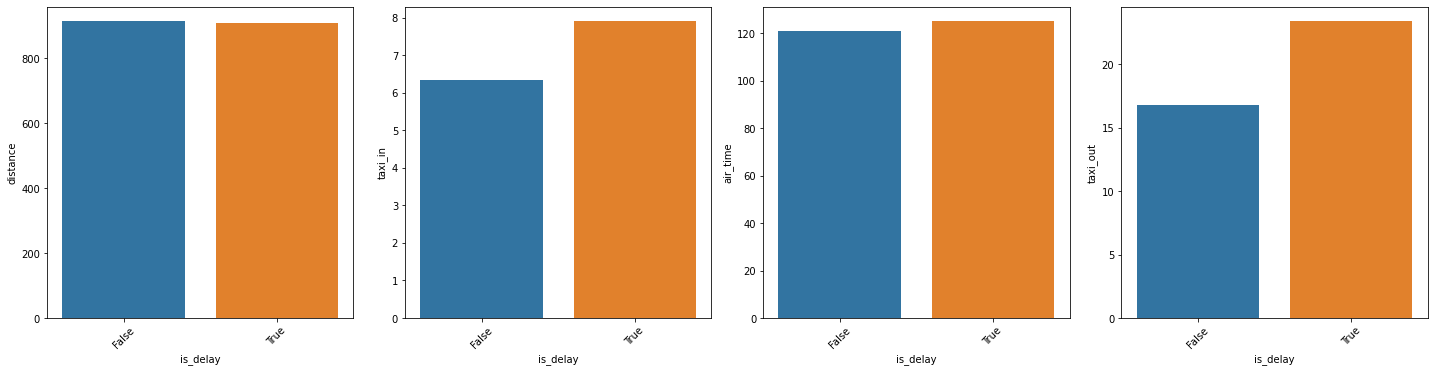

In [59]:
f = plt.figure(figsize=(25,20))
list_of_values = ["distance", "taxi_in", "air_time", "taxi_out"]

for count, element in enumerate(list_of_values):
    f.add_subplot(4,5, count+1)
    sns.barplot(data=df, x="is_delay", y=element, ci=False)

    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that there doesn't seem to be major difference between the remaining features. One of the surpises was distance. I was very surprised that the distance of the flight doesn't seem to make a difference on whether the flights are delayed. 

With this - I have enough information to move onto a first phase of modeling.

# Preprocessing

For modeling purposes, I think the best features would be:

* Is the destination a major airport?
* What is the day / time of the flight?
* What is the airport?
* What is the airline carrier?

In [60]:
df = wrangle.prep_flight_data()

In [61]:
# df = df[(df.op_carrier == "AA") | (df.op_carrier == "DL")]

In [62]:
df.fl_date = pd.to_datetime(df.fl_date)

In [63]:
df["day_of_week"] = df.fl_date.dt.dayofweek

In [64]:
df["month"] = df.fl_date.dt.month

In [65]:
df["airport_avg_delay"] = df.groupby("origin").arr_delay.transform("mean")

In [66]:
df["dest_airport_avg_delay"] = df.groupby("dest").arr_delay.transform("mean")

In [67]:
# # We will look to see if the airport is on of the top five airports that experience delays
# top_airports = df.groupby("origin").arr_delay.mean().nlargest(5).index

# for i in top_airports:
#     df.loc[df['origin'] == i, 'is_top_delay'] = 1
    
# df.is_top_delay = df.is_top_delay.fillna(0)

In [68]:
# We will use the mean delay as a representation of the airline

df["carrier_avg_delay"] = df.groupby("op_carrier").arr_delay.transform("mean")

In [69]:
# # We will look to see if the airport is on of the top five airports that experience delays
# top_carriers= df.groupby("op_carrier").arr_delay.mean().nlargest(5).index

# for i in top_carriers:
#     df.loc[df['op_carrier'] == i, 'is_delay_carrier'] = 1
    
# df.is_delay_carrier = df.is_delay_carrier.fillna(0)

In [70]:
# Lets add our target variable

df['is_delay'] = df['arr_delay'].apply(lambda x: True if x > 0 else False)

In [71]:
df["observation"] = df.fl_date.astype(str) + "_" + df.op_carrier + "_" + df.op_carrier_fl_num.astype(str)

In [72]:
features_for_modeling = ["dest_airport_avg_delay", "carrier_avg_delay", "airport_avg_delay", "crs_dep_time", "crs_arr_time", "month", "day_of_week", "is_delay", "observation"]

df_modeling = df[features_for_modeling]

Before we begin modeling, we need to add observations for the index.

In [73]:
df_modeling = df_modeling.set_index("observation")

In [74]:
df_modeling.head()

,dest_airport_avg_delay,carrier_avg_delay,airport_avg_delay,crs_dep_time,crs_arr_time,month,day_of_week,is_delay
observation,,,,,,,,
2018-01-01_AA_419,4.427472,6.861925,10.246579,705,1056,1,0,False
2018-01-01_AA_420,6.430783,6.861925,1.570023,1148,1720,1,0,False
2018-01-01_AA_422,5.908550,6.861925,2.123515,2259,458,1,0,True
2018-01-01_AA_424,-1.555229,6.861925,2.123515,1626,2208,1,0,True
2018-01-01_AA_424,5.500477,6.861925,1.894642,1229,1530,1,0,True


In [75]:
train, test = train_test_split(df_modeling, random_state = 123, train_size= 0.75)
train, validate = train_test_split(train, random_state = 123, train_size= 0.75)

In [76]:
train.shape, validate.shape, test.shape

((558162, 8), (186055, 8), (248073, 8))

In [77]:
X_train = train.drop(columns="is_delay")
y_train = train["is_delay"]
X_validate = validate.drop(columns="is_delay")
y_validate = validate.is_delay
X_test = test.drop(columns="is_delay")
y_test = test.is_delay

In [78]:
def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

In [79]:
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

# Modeling

In [80]:
train.is_delay.mean()

0.3558303861602904

## Random Forest

In [81]:
# model.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, 8)

In [82]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 5)

In [84]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.65
        False  True 
False  344138  15413
True   177273  21338


,False,True,accuracy,macro avg,weighted avg
precision,0.660013,0.580610,0.654785,0.620311,0.631759
recall,0.957133,0.107436,0.654785,0.532284,0.654785
f1-score,0.781278,0.181321,0.654785,0.481299,0.567795
support,359551.000000,198611.000000,0.654785,558162.000000,558162.000000


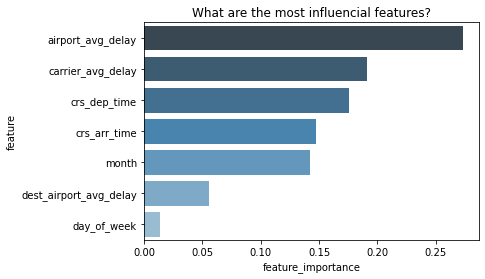

In [85]:
model.rf_feature_importance(rf, X_train)

# KNN

In [ ]:
# model.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, 10)

In [86]:
knn, y_pred = model.run_knn(train_scaled, y_train, 3)

In [87]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.79
        False   True 
False  314139   45412
True    72705  125906


,False,True,accuracy,macro avg,weighted avg
precision,0.812056,0.734926,0.788382,0.773491,0.784611
recall,0.873698,0.633933,0.788382,0.753815,0.788382
f1-score,0.841750,0.680704,0.788382,0.761227,0.784445
support,359551.000000,198611.000000,0.788382,558162.000000,558162.000000


In [88]:
knn.score(validate_scaled, y_validate)

0.6121254467764908

## Gradient Boosting Classifier

In [89]:
def run_gb(X_train, y_train):
    gb = GradientBoostingClassifier(random_state = 123, n_estimators=300, learning_rate=0.003, max_depth=5).fit(X_train, y_train)
    y_pred = gb.predict(X_train)
    return gb, y_pred

In [90]:
gb, y_pred = run_gb(train_scaled, y_train)

In [91]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.65
        False  True 
False  354778   4773
True   189852   8759


,False,True,accuracy,macro avg,weighted avg
precision,0.651411,0.647281,0.651311,0.649346,0.649941
recall,0.986725,0.044101,0.651311,0.515413,0.651311
f1-score,0.784750,0.082576,0.651311,0.433663,0.534895
support,359551.000000,198611.000000,0.651311,558162.000000,558162.000000


# Evaluate

In [141]:
features_for_modeling = ["dest_airport_avg_delay", "carrier_avg_delay", "airport_avg_delay", "crs_dep_time", "crs_arr_time", "month", "day_of_week"]
target_variable = "is_delay"

In [142]:
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = preprocessing.main_modeling_prep(features_for_modeling, target_variable)

In [143]:
knn, y_pred = model.run_knn(train_scaled, y_train, 3)

In [144]:
y_pred = knn.predict(test_scaled)

In [145]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_test)

print(accuracy_score)
print(matrix)

report

Accuracy on dataset: 0.61
        False   True 
False  335144  129518
True   163120  113658


,False,True,accuracy,macro avg,weighted avg
precision,0.672623,0.467390,0.605311,0.570007,0.596010
recall,0.721264,0.410647,0.605311,0.565955,0.605311
f1-score,0.696095,0.437185,0.605311,0.566640,0.599444
support,464662.000000,276778.000000,0.605311,741440.000000,741440.000000


# Conclusion

It seems that KNN is the best model for this task. We are only able to get a 61% accuracy on our test data, which is less than ideal. I believe that the reason for this is because there are other factors, beyond just those present in the data, that lead to a flight getting delayed. 

As we saw from the data, the missing variables that we could bring in to further improve the model are:

1. Weather data
1. Previous flight information
    * We saw that actually the biggest reason for a flight delay is because the plane arrived late. If we could perhaps find a way to actually track that information, we could further enhanced the model. A way to actually accomplish this is to perhaps use the mean delay avg in minutes for the previous flight.